# Challenge: Factors that affect life expectancy


Throughout this module, we dove deep into the topics of exploratory data analysis (EDA) and its substeps. Now it's time to apply your knowledge. In this challenge, you'll work with the [Life Expectancy dataset](https://www.kaggle.com/kumarajarshi/life-expectancy-who/home) from Kaggle. The data is collected from the websites of the World Health Organisation (WHO) and World Bank (WB). The dataset contains annual variables for many of the countries in the world which are divided into several broad categories: immunization related factors, mortality factors, economical factors, and social factors.

You should access the data from the Thinkful database. Here's the credentials you can use to connect to the database:

postgres_user = 'dsbc_student'<br>
postgres_pw = '7\*.8G9QH21'<br>
postgres_host = '142.93.121.174'<br>
postgres_port = '5432'<br>
postgres_db = 'lifeexpectancy'<br>
table_name = 'lifeexpectancy'<br>

To complete this challenge, submit a Jupyter notebook containing your solutions to the following tasks. Moreover, you can also submit a kernel to the Kaggle containing your solutions.

* Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

* First, load the dataset.

* Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them. 

* Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

* In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

* Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

lifeexpectancy_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()


In [2]:
# FInd number of rows and columns in the data frame as well as the data type of each column
lifeexpectancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

As we can see from the output, this dataset contains 2,938 observations and 22 columns. It appears that only the Country and Status fields are objects (which means that they are strings).

Also this data set is time-series dataset. Our target/outcome variable is Life Expectancy. 

In [3]:
# If there are any infinite values in the dataframe then replace with NaN values

lifeexpectancy_df = lifeexpectancy_df.replace(-np.inf, np.nan)

lifeexpectancy_df = lifeexpectancy_df.replace(np.inf, np.nan)

In [4]:
lifeexpectancy_df.nunique()

Country                             193
Year                                 16
Status                                2
Life expectancy                     362
Adult Mortality                     425
infant deaths                       209
Alcohol                            1076
percentage expenditure             2328
Hepatitis B                          87
Measles                             958
 BMI                                608
under-five deaths                   252
Polio                                73
Total expenditure                   818
Diphtheria                           81
 HIV/AIDS                           200
GDP                                2490
Population                         2278
 thinness  1-19 years               200
 thinness 5-9 years                 207
Income composition of resources     625
Schooling                           173
dtype: int64

In [5]:
lifeexpectancy_df.isnull()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [6]:
# Check the rows with NaN values

lifeexpectancy_df[lifeexpectancy_df.isna().any(axis=1)]

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
32,Algeria,2015,Developing,75.6,19.0,21,NaN,0.000000,95.0,63,...,95.0,NaN,95.0,0.1,4132.762920,39871528.0,6.0,5.8,0.743,14.4
37,Côte d'Ivoire,2001,Developing,47.8,467.0,65,3.15,0.000000,1.0,5790,...,7.0,4.85,66.0,7.0,NaN,NaN,7.9,7.9,NaN,NaN
45,Algeria,2003,Developing,71.7,146.0,20,0.34,25.018523,NaN,15374,...,87.0,3.60,87.0,0.1,294.335560,3243514.0,6.3,6.1,0.663,11.5
46,Algeria,2002,Developing,71.6,145.0,20,0.36,148.511984,NaN,5862,...,86.0,3.73,86.0,0.1,1774.336730,3199546.0,6.3,6.2,0.653,11.1
47,Algeria,2001,Developing,71.4,145.0,20,0.23,147.986071,NaN,2686,...,89.0,3.84,89.0,0.1,1732.857979,31592153.0,6.4,6.3,0.644,10.9
48,Algeria,2000,Developing,71.3,145.0,21,0.25,154.455944,NaN,0,...,86.0,3.49,86.0,0.1,1757.177970,3118366.0,6.5,6.4,0.636,10.7
49,Angola,2015,Developing,52.4,335.0,66,NaN,0.000000,64.0,118,...,7.0,NaN,64.0,1.9,3695.793748,2785935.0,8.3,8.2,0.531,11.4
58,Angola,2006,Developing,47.7,381.0,90,5.84,25.086888,NaN,765,...,36.0,4.54,34.0,2.5,262.415149,2262399.0,9.8,9.7,0.439,7.2
59,Angola,2005,Developing,47.4,382.0,92,5.04,98.191451,NaN,258,...,39.0,4.10,38.0,2.6,1443.991929,19552542.0,1.0,9.9,0.426,6.8
60,Angola,2004,Developing,47.1,386.0,94,3.53,8.866777,NaN,29,...,4.0,4.71,4.0,2.5,141.868440,18865716.0,1.2,1.1,0.415,6.4


In [7]:
# Let's calculate the percentages of the missing values in all columns:

lifeexpectancy_df.isnull().sum()*100/lifeexpectancy_df.isnull().count()

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.340368
Adult Mortality                     0.340368
infant deaths                       0.000000
Alcohol                             6.603131
percentage expenditure              0.000000
Hepatitis B                        18.822328
Measles                             0.000000
 BMI                                1.157250
under-five deaths                   0.000000
Polio                               0.646698
Total expenditure                   7.692308
Diphtheria                          0.646698
 HIV/AIDS                           0.000000
GDP                                15.248468
Population                         22.191967
 thinness  1-19 years               1.157250
 thinness 5-9 years                 1.157250
Income composition of resources     5.684139
Schooling                           5.547992
dtype: flo

In [8]:
lifeexpectancy_df.Status.value_counts()

Developing    2426
Developed      512
Name: Status, dtype: int64

In [9]:
from scipy.stats import zscore
import numpy as np

# Function to fill mean value for each column
def fillna_mean (df, column_name):

    return df[column_name].fillna(df[column_name].mean(), inplace=True)

# function to fill mean values for all specified columns in the list:
def fillna_mean_columns(df, col_list):

    for col in col_list:
    
        fillna_mean(df, col)

# Print Z-scores for a specified column
def print_zscore(df, col_list):
    
    for col in col_list:
        print(col)
        z_scores = zscore(df[col])
        for threshold in range(1,5):
            print("The score threshold is: {}".format(threshold))
            print("The indices of the outliers:")
            print(np.where(z_scores > threshold))
            print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))
        

# Function t0 visualize the data
def visualize_column (df, column_name):
        plt.figure(figsize=(16,4)) 
        
        # histograms of the original data
        plt.subplot(1, 4, 1)
        plt.hist(df[column_name])
        plt.title("histogram of {} (original)".format(column_name))

        # histograms of the log transformed data
        plt.subplot(1, 4, 2)
        plt.hist(np.log(df[column_name]))
        plt.title("histogram of {} (log transformed)".format(column_name))

        # histograms of the interpolated data
        plt.subplot(1, 4, 3)
        plt.hist(df[column_name].interpolate())
        plt.title("histogram of {} (interpolated)".format(column_name))
        
        # histograms of the winsorized data
        winsorized_column = "winsorized_" + column_name
        plt.subplot(1, 4, 4)
        df[winsorized_column] = winsorized_views = winsorize(df[column_name], (0, 0.10))
        plt.hist(df[winsorized_column])
        plt.title("histogram of {} (winsorized)".format(column_name))
        
        plt.show()
    

In [9]:
lifeexpectancy_df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

In [10]:
cols = ["Diphtheria ", "Adult Mortality", "Alcohol", "Hepatitis B", " BMI ", "Polio", "Total expenditure", "GDP", "Population", "Income composition of resources", "Schooling"]

fillna_mean_columns(lifeexpectancy_df,cols)

In [11]:
lifeexpectancy_df.isnull().sum()*100/lifeexpectancy_df.isnull().count()

Country                            0.000000
Year                               0.000000
Status                             0.000000
Life expectancy                    0.340368
Adult Mortality                    0.000000
infant deaths                      0.000000
Alcohol                            0.000000
percentage expenditure             0.000000
Hepatitis B                        0.000000
Measles                            0.000000
 BMI                               0.000000
under-five deaths                  0.000000
Polio                              0.000000
Total expenditure                  0.000000
Diphtheria                         0.000000
 HIV/AIDS                          0.000000
GDP                                0.000000
Population                         0.000000
 thinness  1-19 years              1.157250
 thinness 5-9 years                1.157250
Income composition of resources    0.000000
Schooling                          0.000000
dtype: float64

In [12]:
 print_zscore(lifeexpectancy_df,cols)

Diphtheria 
The score threshold is: 1
The indices of the outliers:
(array([], dtype=int64),)
Number of outliers is: 0
The score threshold is: 2
The indices of the outliers:
(array([], dtype=int64),)
Number of outliers is: 0
The score threshold is: 3
The indices of the outliers:
(array([], dtype=int64),)
Number of outliers is: 0
The score threshold is: 4
The indices of the outliers:
(array([], dtype=int64),)
Number of outliers is: 0
Adult Mortality
The score threshold is: 1
The indices of the outliers:
(array([   8,    9,   10,   11,   12,   14,   15,   37,   49,   50,   51,
         52,   53,   54,   55,   56,   57,   58,   59,   60,   61,   62,
        304,  341,  342,  343,  344,  345,  346,  347,  348,  349,  350,
        351,  352,  409,  411,  412,  413,  414,  415,  416,  418,  420,
        421,  423,  425,  426,  427,  428,  429,  430,  431,  432,  433,
        435,  436,  437,  438,  439,  440,  441,  442,  443,  444,  445,
        446,  447,  480,  481,  482,  483,  484,  486,

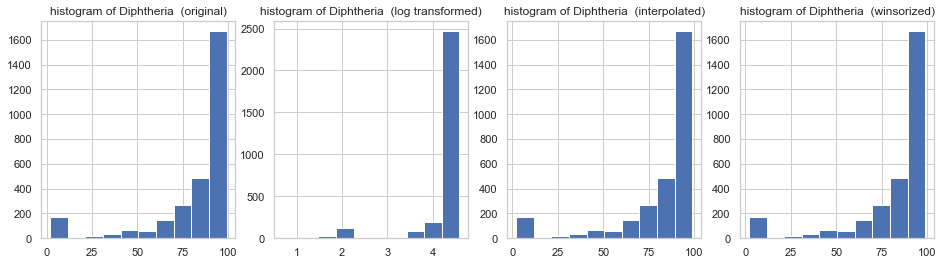

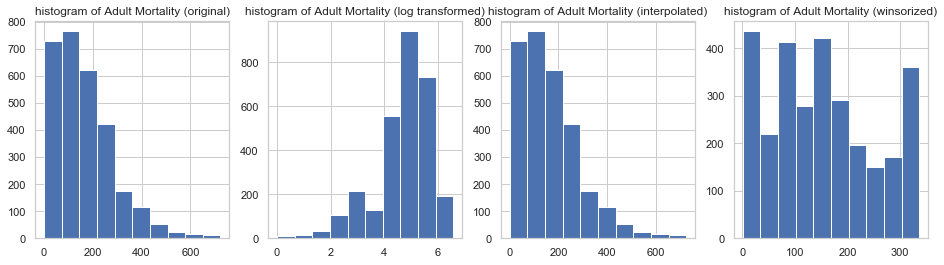

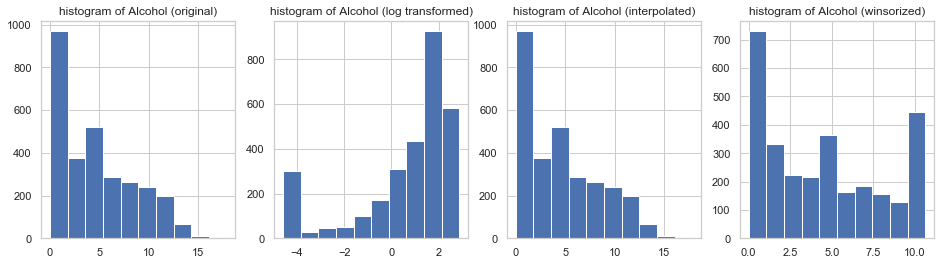

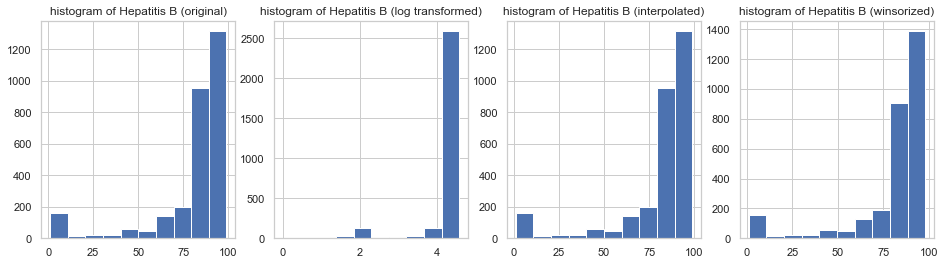

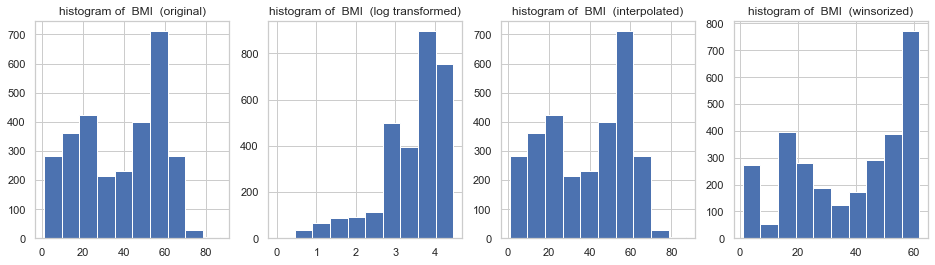

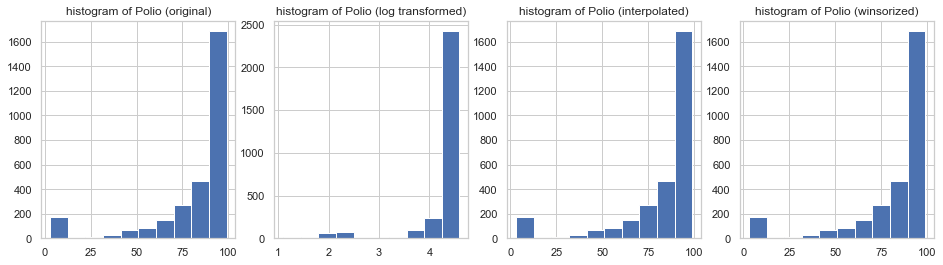

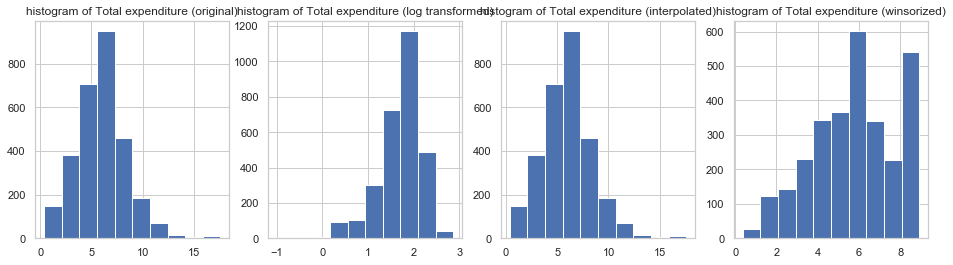

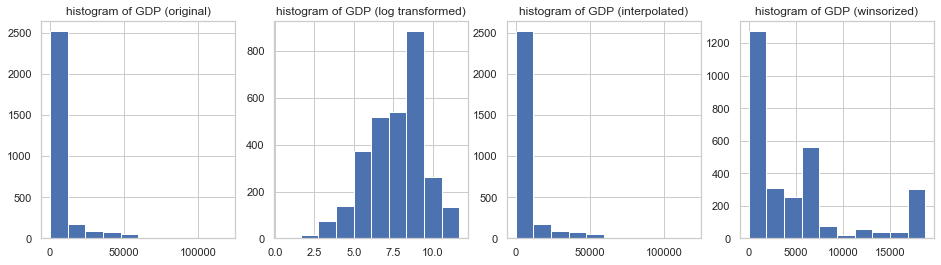

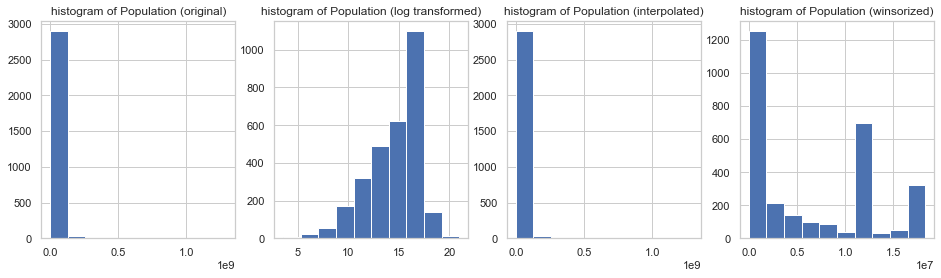

ValueError: supplied range of [-inf, -0.053400776727115296] is not finite

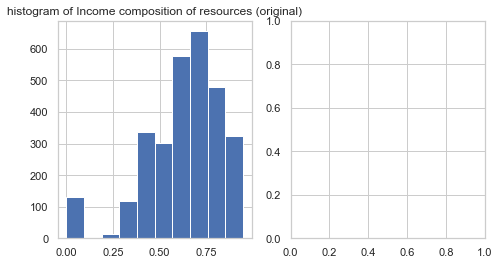

In [13]:
    for col in cols:
        visualize_column(lifeexpectancy_df,col)

In [15]:
from numpy import inf 

x = np.array(lifeexpectancy_df['Income composition of resources'])

x[x == -inf] = 0

lifeexpectancy_df['Income composition of resources'] = x




In [17]:
lifeexpectancy_df['Income composition of resources'] = [np.log(x) for x in lifeexpectancy_df['Income composition of resources']]



ValueError: autodetected range of [nan, nan] is not finite

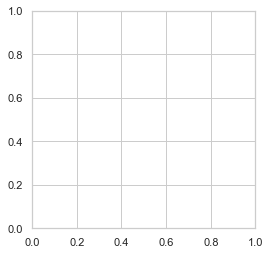

In [21]:
plt.figure(figsize=(4,4)) 

plt.hist(lifeexpectancy_df['Income composition of resources'])

plt.show()

In [16]:
# Get descriptive statistics

lifeexpectancy_df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,...,Income composition of resources,Schooling,winsorized_Adult Mortality,winsorized_Alcohol,winsorized_Hepatitis B,winsorized_ BMI,winsorized_Polio,winsorized_Total expenditure,winsorized_GDP,winsorized_Population
count,2938.000000,2928.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,...,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,...,0.627551,11.992793,155.205230,4.454362,80.858773,37.913452,82.550188,5.776535,5239.674888,6.637598e+06
std,4.613841,9.523867,124.080302,117.926501,3.916288,1987.914858,22.586855,11467.272489,19.927677,160.445548,...,0.204820,3.264381,101.258628,3.627305,22.523089,19.349251,23.352143,2.045229,5817.290436,6.581355e+06
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.010000,1.000000,1.000000,3.000000,0.370000,1.681350,3.400000e+01
25%,2004.000000,63.100000,74.000000,0.000000,1.092500,4.685343,80.940461,0.000000,19.400000,0.000000,...,0.504250,10.300000,74.000000,1.092500,80.940461,19.400000,78.000000,4.370000,580.486996,4.189172e+05
50%,2008.000000,72.100000,144.000000,3.000000,4.160000,64.912906,87.000000,17.000000,43.000000,4.000000,...,0.662000,12.100000,144.000000,4.160000,87.000000,43.000000,93.000000,5.938190,3116.561755,3.675929e+06
75%,2012.000000,75.700000,227.000000,22.000000,7.390000,441.534144,96.000000,360.250000,56.100000,28.000000,...,0.772000,14.100000,227.000000,7.390000,96.000000,56.100000,97.000000,7.330000,7483.158469,1.275338e+07
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,...,0.948000,20.700000,336.000000,10.620000,98.000000,61.800000,99.000000,8.910000,18784.948500,1.829461e+07


In [98]:
# Make a copy of lifeexpectancy_df
df2 = lifeexpectancy_df

# Drop unnecessary attibutes
df2 = df2.drop(labels = ["winsorized_Adult Mortality","winsorized_Alcohol","winsorized_Hepatitis B","winsorized_ BMI ","winsorized_Polio", "winsorized_Total expenditure", "winsorized_GDP", "winsorized_Population"], axis = 1)

df2.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,...,Income composition of resources,Schooling,winsorized_Adult Mortality,winsorized_Alcohol,winsorized_Hepatitis B,winsorized_ BMI,winsorized_Polio,winsorized_Total expenditure,winsorized_GDP,winsorized_Population
count,2938.000000,2928.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,...,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,...,0.627551,11.992793,155.205230,4.454362,80.858773,37.913452,82.550188,5.776535,5239.674888,6.637598e+06
std,4.613841,9.523867,124.080302,117.926501,3.916288,1987.914858,22.586855,11467.272489,19.927677,160.445548,...,0.204820,3.264381,101.258628,3.627305,22.523089,19.349251,23.352143,2.045229,5817.290436,6.581355e+06
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.010000,1.000000,1.000000,3.000000,0.370000,1.681350,3.400000e+01
25%,2004.000000,63.100000,74.000000,0.000000,1.092500,4.685343,80.940461,0.000000,19.400000,0.000000,...,0.504250,10.300000,74.000000,1.092500,80.940461,19.400000,78.000000,4.370000,580.486996,4.189172e+05
50%,2008.000000,72.100000,144.000000,3.000000,4.160000,64.912906,87.000000,17.000000,43.000000,4.000000,...,0.662000,12.100000,144.000000,4.160000,87.000000,43.000000,93.000000,5.938190,3116.561755,3.675929e+06
75%,2012.000000,75.700000,227.000000,22.000000,7.390000,441.534144,96.000000,360.250000,56.100000,28.000000,...,0.772000,14.100000,227.000000,7.390000,96.000000,56.100000,97.000000,7.330000,7483.158469,1.275338e+07
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,...,0.948000,20.700000,336.000000,10.620000,98.000000,61.800000,99.000000,8.910000,18784.948500,1.829461e+07


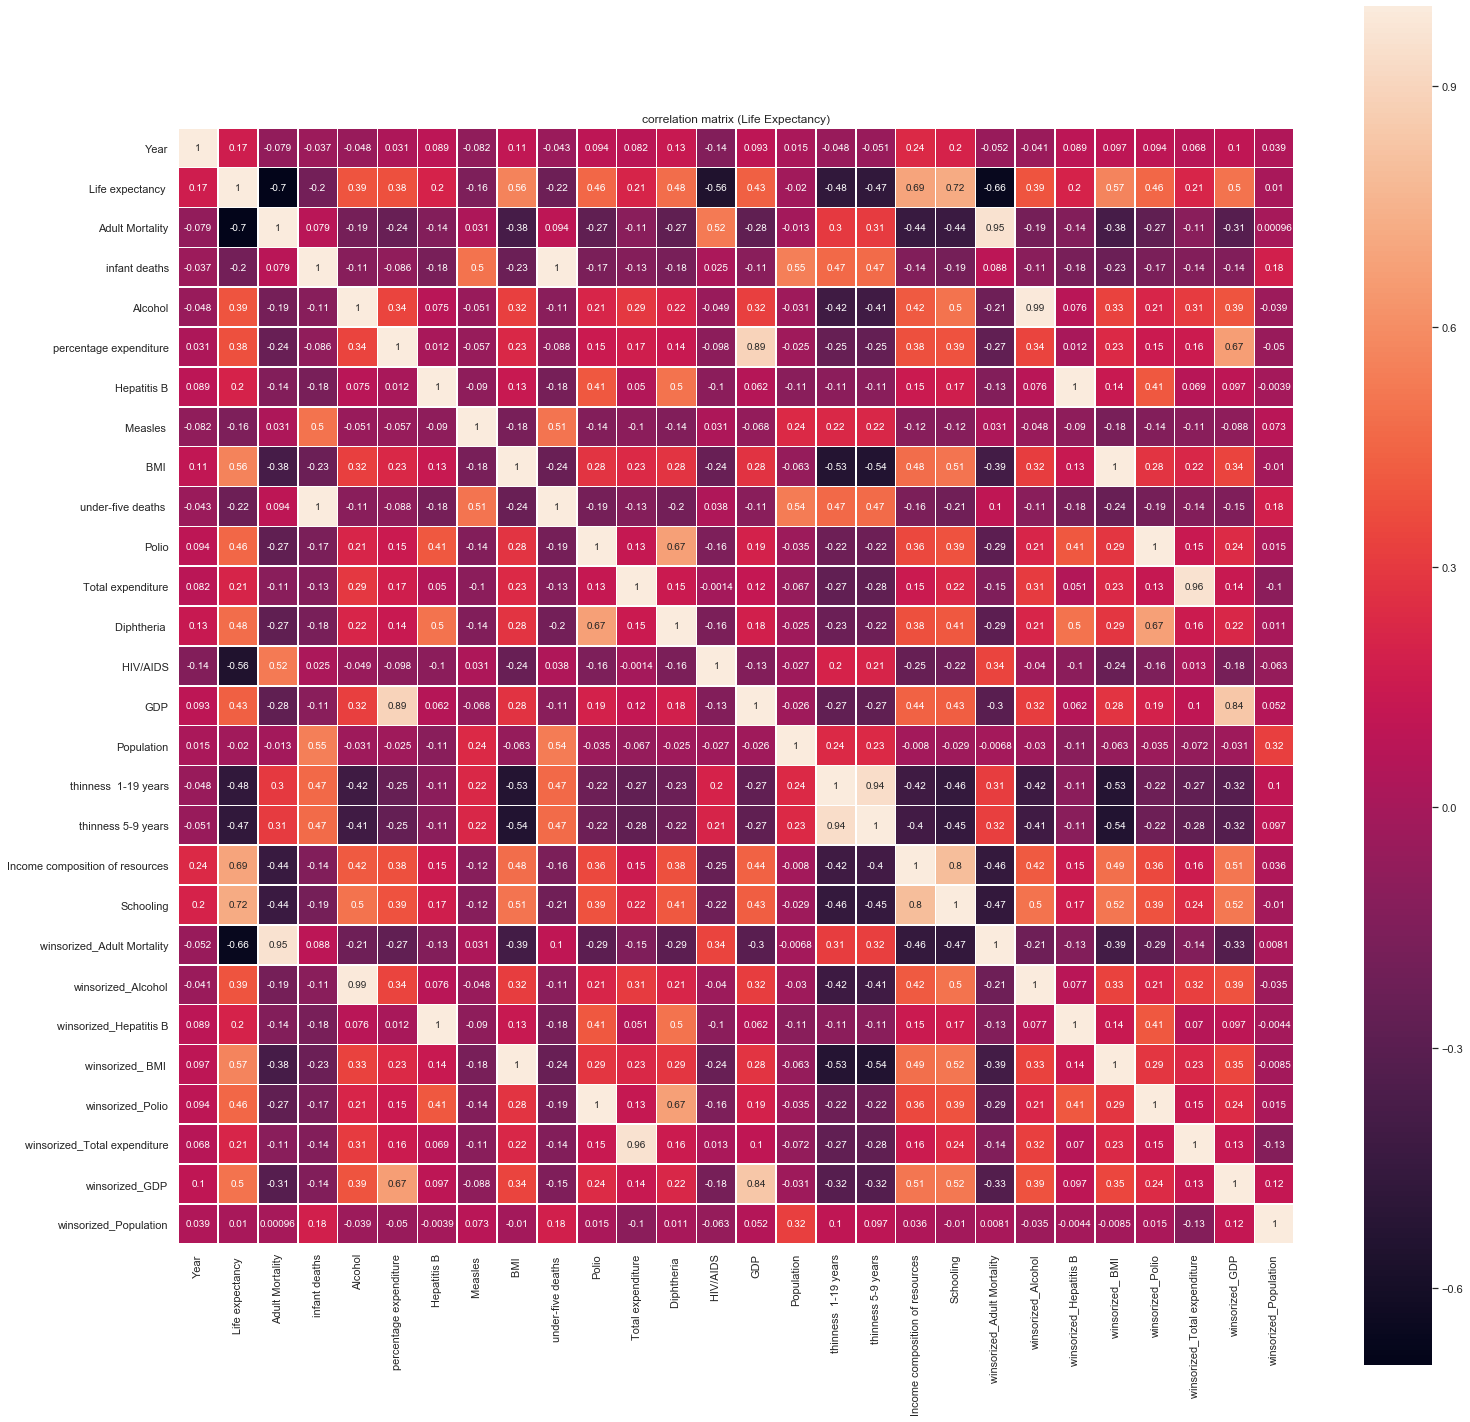

In [19]:
# make the correlation matrice.
corrmat = df2.corr()

# heatmaps are a great way to get 
# a quick visual read on a big correlation matrix.

plt.figure(figsize=(25,25))

# draw the heatmap using seaborn.
sns.heatmap(corrmat, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (Life Expectancy)")


plt.show()

# try to match the correlation numbers 
# to the scatterplots above to get a 
# sense of what each magnitude of 
# correlation can look like.
